Script for testing different density estimation methods.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# custom libs
import sys
sys.path.append("..")
from src.dynamicFPC import K_dFPC, W_dFPC
from src.transformations import mLQDT, obtain_densities_from_lqd
from src.forecasting import overall_measures
from src.preprocessing import align_densities

In [2]:
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from sklearn.neighbors import KernelDensity

In [3]:
# Dados
data_path = "../data/processed/"
returns_path = ''.join([data_path, 'ibovespa_treated.xlsx'])
df = pd.read_excel(returns_path, index_col="time")
df.head()

,2024-12-02,2024-12-03,2024-12-04,2024-12-05,2024-12-06,2024-12-09,2024-12-10,2024-12-11,2024-12-12,2024-12-13,...,2025-11-14,2025-11-17,2025-11-18,2025-11-19,2025-11-21,2025-11-24,2025-11-25,2025-11-26,2025-11-27,2025-11-28
time,,,,,,,,,,,,,,,,,,,,,
10:00:00,0.000011,-0.000372,-0.000035,0.007233,-0.001305,-0.000459,0.002388,0.002212,-0.008001,-0.000824,...,-0.000957,-0.002307,-0.003734,-0.005020,-0.001139,-0.000255,0.002339,0.004176,-0.000224,-0.000238
10:05:00,-0.002271,0.003372,0.001716,0.005538,0.000069,0.006429,0.002343,0.001918,-0.007582,-0.000413,...,-0.001522,0.000739,-0.000613,0.000306,-0.002021,-0.000810,0.001557,-0.001565,-0.000193,0.002906
10:10:00,-0.000582,0.002832,-0.000502,0.000739,0.000261,0.001891,0.000775,-0.001172,0.000216,-0.000432,...,0.000360,-0.000105,-0.000159,-0.000362,0.000092,0.001131,0.001170,0.000202,0.000556,0.000475
10:15:00,-0.001997,0.001091,0.000111,-0.000192,0.000407,-0.001392,-0.000477,-0.001526,0.000198,-0.001821,...,0.001121,-0.000284,0.003272,-0.001107,-0.001012,-0.000174,0.001002,0.001815,-0.000168,0.000973
10:20:00,-0.000037,-0.000505,-0.000327,-0.000580,-0.000436,-0.000405,0.001263,0.000676,-0.002667,0.001033,...,0.000449,0.000335,0.000853,0.000981,-0.000057,-0.000096,0.000832,0.001951,0.001060,-0.001004


In [4]:
sk_kernels = [
    "gaussian",
    "tophat",
    "epanechnikov",
    "exponential",
    "linear",
    "cosine",
]

<Axes: >

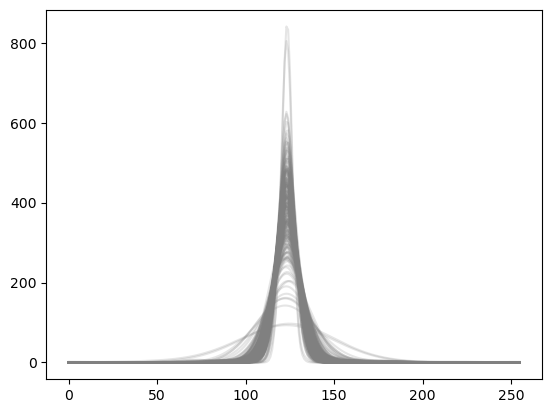

In [191]:
m = 256
x_grid = np.linspace(df.min().min(), df.max().max(), 256)
l = []
for t in df.columns:
    kde = gaussian_kde(df[t], bw_method=1.0)
    l.append(pd.Series(kde(x_grid)))

df_density = pd.concat(l, axis=1)
df_density.columns = df.columns
df_supports = pd.concat([pd.Series(x_grid) for r in range(len(df.columns))], axis=1)
df_supports.columns = df.columns

df_density.plot(legend=False, color="gray", alpha=.2)

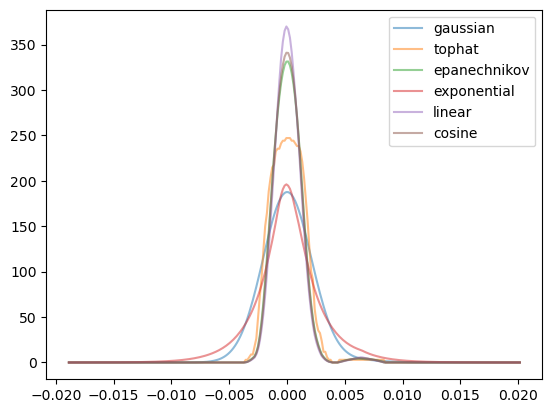

In [194]:
l=[]

i = 5
t = df.columns[i]
for kernel in sk_kernels:
    kde = KernelDensity(bandwidth = 0.002,kernel=kernel)
    data = df.loc[:,t].values.reshape(-1,1)
    kde.fit(data)
    log_densities = kde.score_samples(x_grid.reshape(-1,1))
    densities = np.exp(log_densities)
    l.append(pd.Series(densities))

df_densities_kernels = pd.concat(l, axis=1)
df_densities_kernels.columns = sk_kernels


plt.figure()
for kernel in df_densities_kernels.columns:
    
    plt.plot(x_grid, df_densities_kernels.loc[:,kernel], label=kernel, alpha=.5)

plt.legend()
plt.show()

In [ ]:
bovespa_mLQDT = mLQDT(
                df_density,
                df_supports
            )
bovespa_mLQDT.densities_to_lqdensities(verbose=False)

cut = 1 # LQDT has boundary problems
df_lqds = bovespa_mLQDT.lqd.iloc[cut:-cut,:]
df_lqds_support = bovespa_mLQDT.lqd_support[cut:-cut]

# df_lqds = bovespa_mLQDT.lqd
# df_lqds_support = bovespa_mLQDT.lqd_support

c:\Users\user\anaconda3\envs\densities4risk\Lib\site-packages\scipy\interpolate\_interpolate.py:497: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\user\anaconda3\envs\densities4risk\Lib\site-packages\scipy\interpolate\_interpolate.py:500: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


<Axes: >

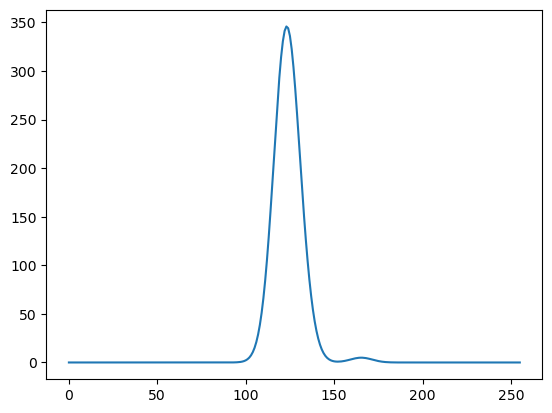

In [222]:
i = 5
col = df_lqds.columns[i]

df_density[col].plot()

<Axes: >

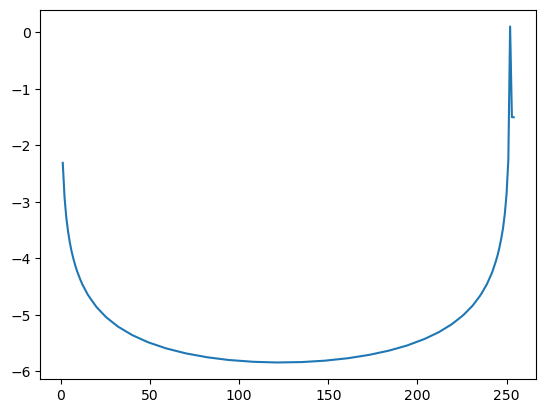

In [223]:
df_lqds[col].plot() # bumps on near the boundaries of support cause spikes on LQDT

In [212]:
KdFPC_kwargs = {
    "lag_max": 5,
    "alpha": 0.10,
    "du": 0.05,
    "B": 1000,
    "p": 5,
    "m": df_lqds.shape[0],
    "u": df_lqds_support,
    "select_ncomp": False,
    "dimension": 2
}

KdFPC_model = K_dFPC(df_lqds.values)
KdFPC_model.fit(**KdFPC_kwargs)
df_yhat = pd.DataFrame(KdFPC_model.fitted_values, columns = df.columns)
df_yhat

,2024-12-02,2024-12-03,2024-12-04,2024-12-05,2024-12-06,2024-12-09,2024-12-10,2024-12-11,2024-12-12,2024-12-13,...,2025-11-14,2025-11-17,2025-11-18,2025-11-19,2025-11-21,2025-11-24,2025-11-25,2025-11-26,2025-11-27,2025-11-28
0,-2.107331,-2.112359,-2.360973,-2.273805,-2.310220,-2.329559,-2.353980,-1.534801,-1.214259,-2.307022,...,-2.157728,-2.215503,-2.049344,-1.853105,-2.040005,-2.488628,-2.020816,-2.479642,-2.921053,-2.445259
1,-2.643794,-2.721853,-2.929532,-3.185690,-2.772911,-3.168633,-2.976949,-2.512061,-1.334229,-2.719528,...,-2.736376,-2.648791,-2.397494,-1.830744,-2.575533,-3.027847,-2.536885,-3.216930,-3.233252,-3.051628
2,-2.915884,-3.148467,-3.207207,-4.217258,-2.837361,-4.031080,-3.372412,-3.866251,-0.939349,-2.677730,...,-3.085949,-2.674003,-2.282303,-0.973930,-2.862318,-3.211301,-2.786923,-3.825073,-2.825304,-3.389057
3,-3.254612,-3.351871,-3.514899,-3.876252,-3.336304,-3.831862,-3.578069,-3.320022,-1.952057,-3.269692,...,-3.351883,-3.216947,-2.964873,-2.323728,-3.195171,-3.588023,-3.153814,-3.832227,-3.673355,-3.635926
4,-3.477869,-3.546018,-3.724332,-3.949290,-3.588113,-3.933673,-3.765857,-3.370050,-2.344871,-3.541504,...,-3.558130,-3.480856,-3.263375,-2.770615,-3.419076,-3.808618,-3.385548,-3.973965,-3.982603,-3.829953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,-3.353882,-3.263999,-3.403874,-2.941889,-3.518698,-3.053130,-3.333086,-2.596791,-3.558806,-3.580555,...,-3.318868,-3.521895,-3.569621,-3.964854,-3.331092,-3.486139,-3.348687,-3.234317,-3.925019,-3.386413
250,-3.113807,-3.002023,-3.145703,-2.584494,-3.293740,-2.715522,-3.058960,-2.244839,-3.472753,-3.370637,...,-3.064542,-3.308876,-3.387535,-3.899630,-3.093563,-3.232398,-3.117595,-2.921940,-3.724262,-3.114152
251,-2.709117,-2.619753,-2.697322,-2.265105,-2.822115,-2.360841,-2.629569,-2.103856,-3.124288,-2.883552,...,-2.662689,-2.847965,-2.934624,-3.369336,-2.702911,-2.747394,-2.724771,-2.502558,-3.074150,-2.659983
252,-2.511406,-2.361076,-2.599789,-1.825015,-2.791008,-2.012219,-2.481191,-1.233727,-2.837740,-2.894469,...,-2.453746,-2.794595,-2.871376,-3.529165,-2.472013,-2.739838,-2.501103,-2.318236,-3.482370,-2.572136


In [213]:
kle_bkw_supports, kle_bkw_densities = obtain_densities_from_lqd(
                                                            df_yhat,
                                                            bovespa_mLQDT.lqd_support,
                                                            bovespa_mLQDT.c,
                                                            verbose=False
                                                            )

In [218]:
df_supp, df_density_observed, df_density_estimated = align_densities(
                                                        df_supports, 
                                                        df_density, 
                                                        kle_bkw_supports, 
                                                        kle_bkw_densities, 
                                                        kle_bkw_densities.columns)

C:\Users\user\AppData\Local\Temp\ipykernel_19584\3076960321.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_obs = np.trapz(f_obs_c, x_common)
C:\Users\user\AppData\Local\Temp\ipykernel_19584\3076960321.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_hat = np.trapz(f_hat_c, x_common)


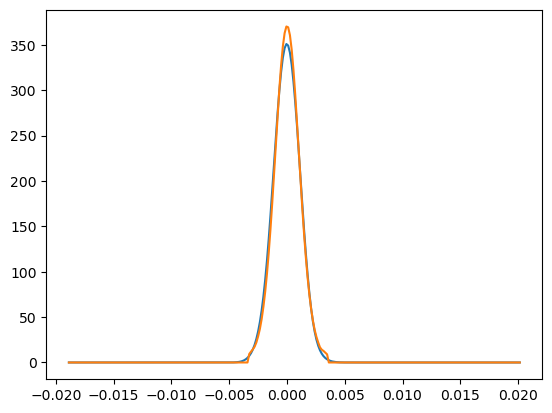

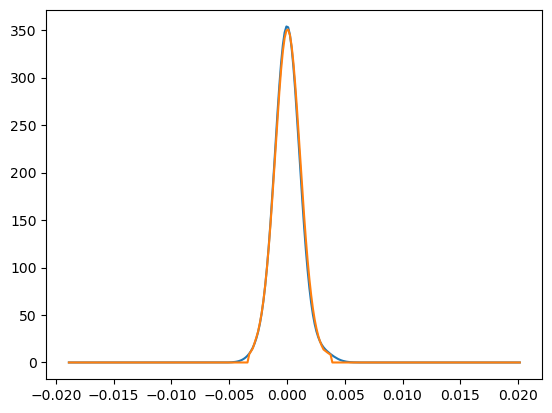

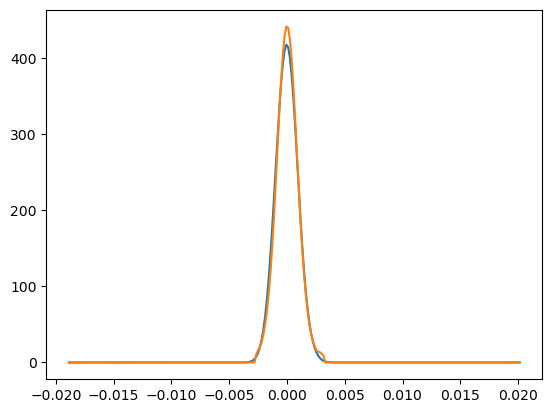

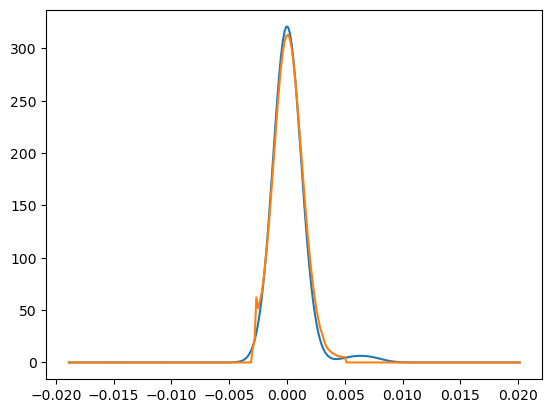

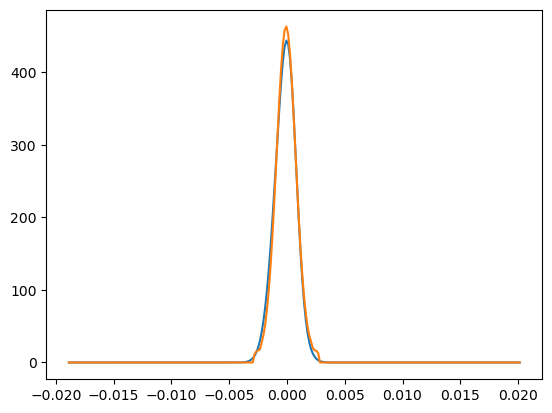

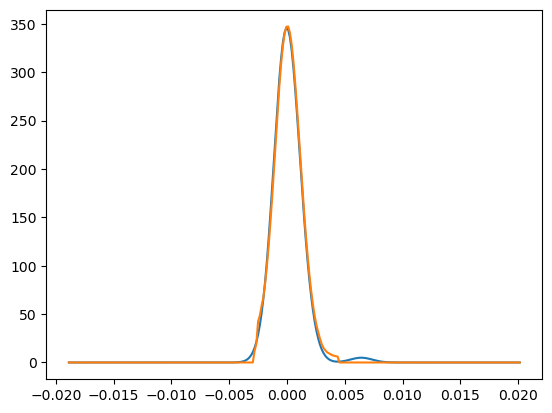

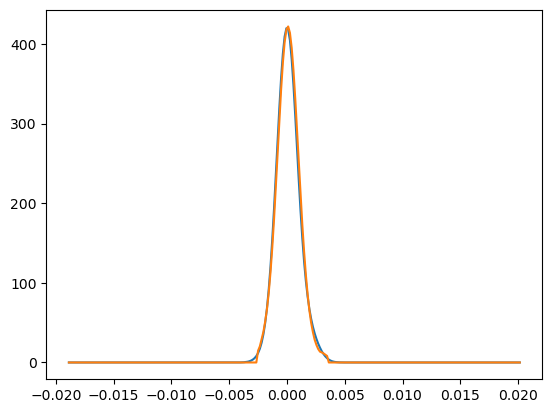

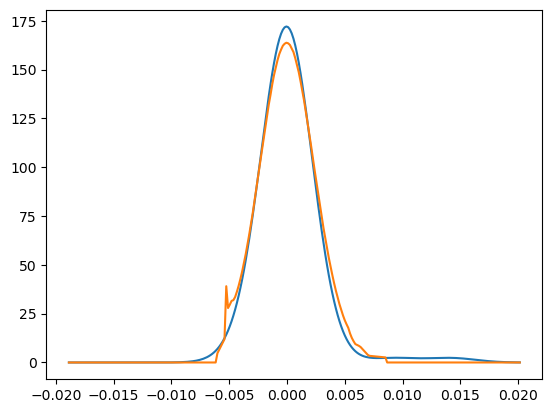

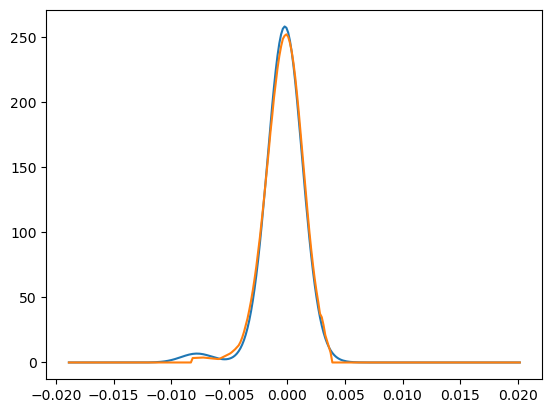

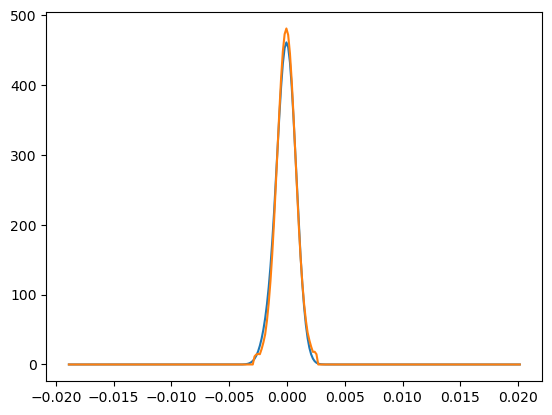

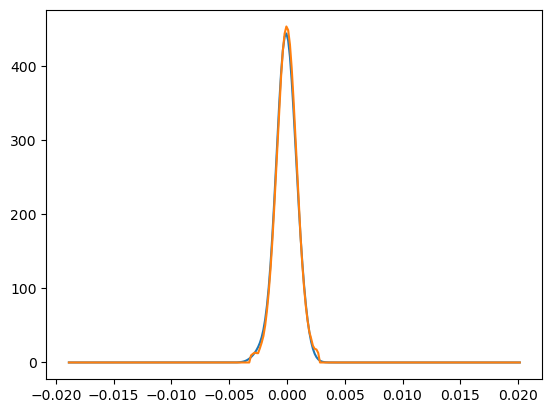

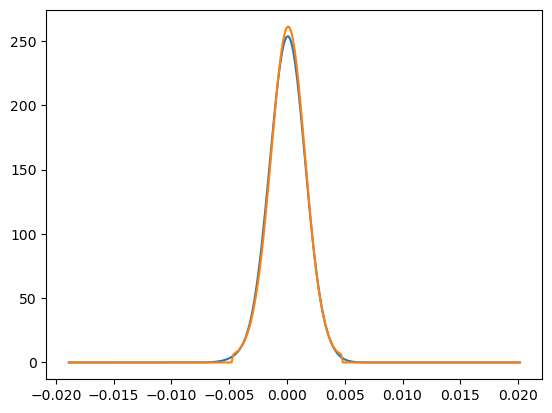

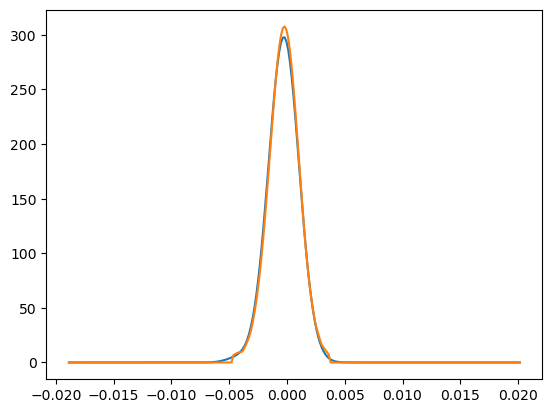

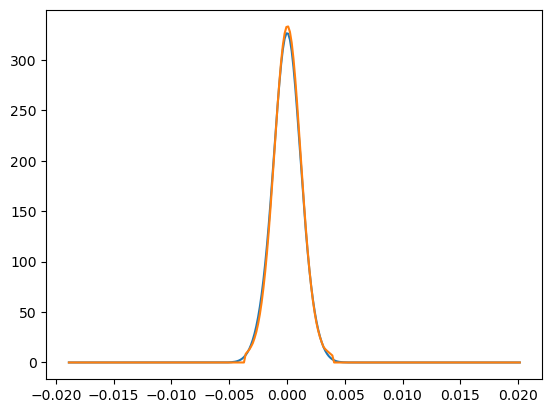

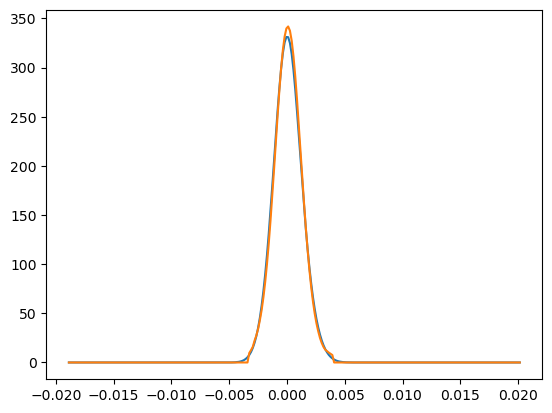

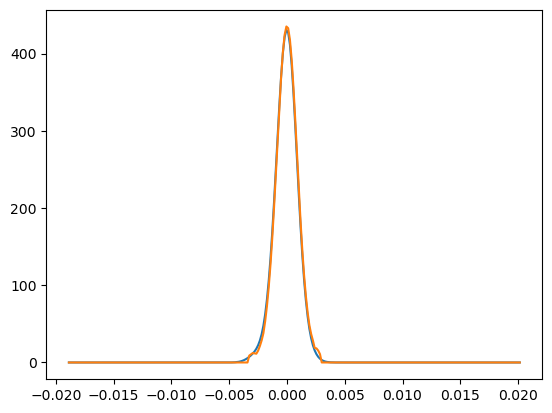

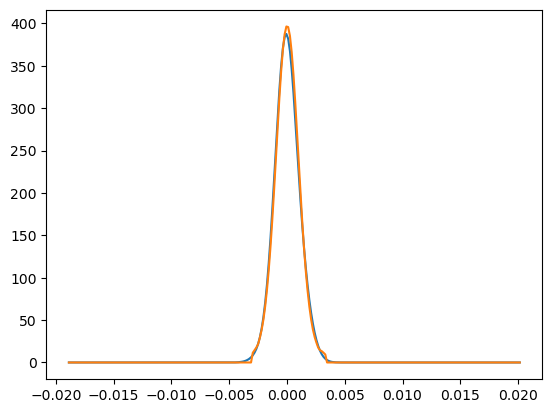

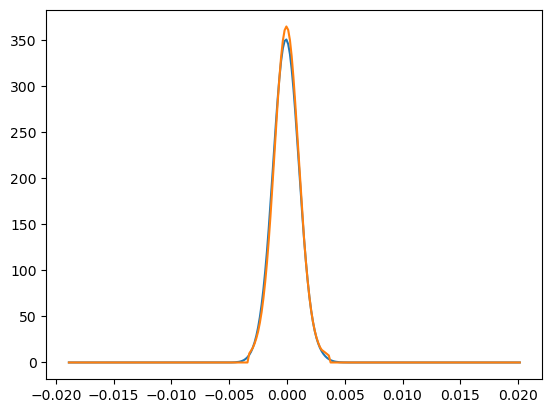

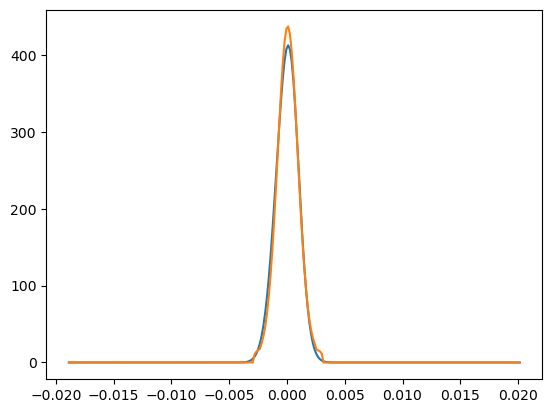

KeyboardInterrupt: 

In [221]:
import time
for i in range(len(df.columns)):
    # i=7
    t = df.columns[i]

    plt.figure()

    # plt.plot(df_supports[t], df_density[t], label="actual")
    # plt.plot(kle_bkw_supports[t], kle_bkw_densities[t], label="estimated")

    plt.plot(df_supp[t], df_density_observed[t], label="actual")
    plt.plot(df_supp[t], df_density_estimated[t], label="estimated")

    plt.show()

    time.sleep(2)

In [44]:
def lqdT_estimateL2_invT(densities, densities_supports, M):
    bovespa_mLQDT = mLQDT(
                    df_density,
                    df_supports
                )
    bovespa_mLQDT.densities_to_lqdensities(verbose=False)
    df_lqds = bovespa_mLQDT.lqd.iloc[1:-1,:]
    df_lqds_support = bovespa_mLQDT.lqd_support[1:-1]

    KdFPC_kwargs = {
        "lag_max": 5,
        "alpha": 0.10,
        "du": 0.05,
        "B": 1000,
        "p": 5,
        "m": df_lqds.shape[0],
        "u": df_lqds_support,
        "select_ncomp": False,
        "dimension": 2
    }

    KdFPC_model = K_dFPC(df_lqds.values)
    KdFPC_model.fit(**KdFPC_kwargs)
    df_yhat = pd.DataFrame(KdFPC_model.fitted_values, columns = df.columns)
    kle_bkw_supports, kle_bkw_densities = obtain_densities_from_lqd(
                                                                df_yhat,
                                                                bovespa_mLQDT.lqd_support,
                                                                bovespa_mLQDT.c
                                                                )
    
    return kle_bkw_supports, kle_bkw_densities


In [45]:
df_est_supports, df_est_densities = lqdT_estimateL2_invT(df_density, df_supports, m)

c:\Users\user\anaconda3\envs\densities4risk\Lib\site-packages\scipy\interpolate\_interpolate.py:497: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\user\anaconda3\envs\densities4risk\Lib\site-packages\scipy\interpolate\_interpolate.py:500: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to closest value.
c not in lqdSup — resetting to clo